In [1]:
# Если нужно, раскомментируй строку ниже для установки requests/pandas
# !pip install requests pandas

import requests
import pandas as pd
from datetime import datetime

In [2]:
BASE_URL = "https://iss.moex.com/iss/history/engines/stock/markets/index/securities/IMOEX.json"

def load_imoex_history(from_date: str, till_date: str) -> pd.DataFrame:
    """
    Загружает историю индекса IMOEX за указанный диапазон дат (включительно)
    через ISS API Московской биржи.

    Параметры:
        from_date: начало периода, строка 'YYYY-MM-DD'
        till_date: конец периода, строка 'YYYY-MM-DD'

    Возвращает:
        pandas.DataFrame с колонками по данным ISS (DATE, CLOSE, OPEN, LOW, HIGH и т.п.)
    """
    all_rows = []
    start = 0          # смещение (pagination)
    step = 100         # размер страницы (по умолчанию 100 у ISS)

    while True:
        params = {
            "from": from_date,
            "till": till_date,
            "start": start
        }

        resp = requests.get(BASE_URL, params=params)
        resp.raise_for_status()
        data = resp.json()

        # В ISS данные в блоке "history"
        columns = data["history"]["columns"]
        rows = data["history"]["data"]

        if not rows:
            # Данные закончились
            break

        # Преобразуем в DataFrame текущую страницу
        df_page = pd.DataFrame(rows, columns=columns)
        all_rows.append(df_page)

        # Готовим смещение к следующей странице
        start += step

    if not all_rows:
        return pd.DataFrame()

    df = pd.concat(all_rows, ignore_index=True)

    # Приведём колонку DATE к datetime и отсортируем
    if "TRADEDATE" in df.columns:
        df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
        df = df.sort_values("TRADEDATE").reset_index(drop=True)

    return df

In [3]:
# Пример: забрать данные за 2024 год
df_imoex_2024 = load_imoex_history("2024-01-01", "2024-12-31")
df_imoex_2024.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,CAPITALIZATION,CURRENCYID,DIVISOR,TRADINGSESSION,VOLUME,TRADE_SESSION_DATE,RECALC_DATE
0,SNDX,IMOEX,2024-01-03,Индекс МосБиржи,Индекс МосБиржи,3130.23,3099.78,3132.76,3099.10,2.599977e+10,0,0,2,5.543797e+12,RUB,1.771050e+09,3,None,2024-01-03,None
1,SNDX,IMOEX,2024-01-04,Индекс МосБиржи,Индекс МосБиржи,3136.07,3140.66,3144.25,3133.93,2.288064e+10,0,0,2,5.554129e+12,RUB,1.771050e+09,3,None,2024-01-04,None
2,SNDX,IMOEX,2024-01-05,Индекс МосБиржи,Индекс МосБиржи,3136.37,3138.27,3142.80,3128.16,2.082244e+10,0,0,2,5.554668e+12,RUB,1.771050e+09,3,None,2024-01-05,None
3,SNDX,IMOEX,2024-01-08,Индекс МосБиржи,Индекс МосБиржи,3158.58,3140.12,3158.82,3139.37,3.554193e+10,0,0,2,5.594009e+12,RUB,1.771050e+09,3,None,2024-01-08,None
4,SNDX,IMOEX,2024-01-09,Индекс МосБиржи,Индекс МосБиржи,3155.55,3156.17,3158.72,3143.03,4.926957e+10,0,0,2,5.588634e+12,RUB,1.771050e+09,3,None,2024-01-09,None


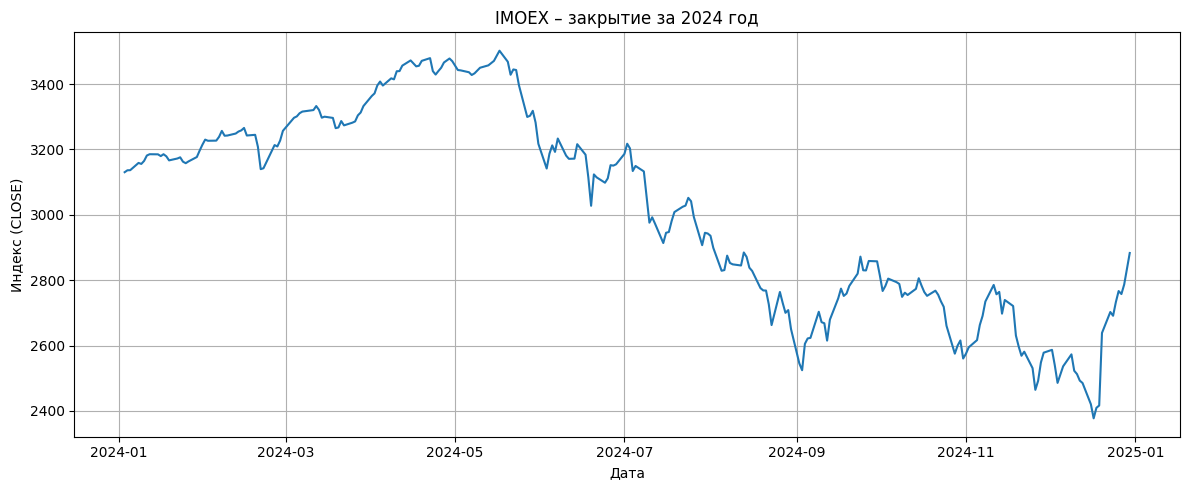

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_imoex_2024["TRADEDATE"], df_imoex_2024["CLOSE"])
plt.title("IMOEX – закрытие за 2024 год")
plt.xlabel("Дата")
plt.ylabel("Индекс (CLOSE)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from pathlib import Path

def save_imoex_to_files(df: pd.DataFrame, base_name: str = "imoex_data", folder: str = "data"):
    """
    Сохраняет DataFrame с индексом IMOEX в CSV и Excel.

    Параметры:
        df        : DataFrame с данными IMOEX
        base_name : базовое имя файла без расширения
        folder    : папка для сохранения файлов
    """
    # создаём папку, если её нет
    folder_path = Path(folder)
    folder_path.mkdir(parents=True, exist_ok=True)

    csv_path = folder_path / f"{base_name}.csv"
    xlsx_path = folder_path / f"{base_name}.xlsx"

    # Сохранение в CSV
    df.to_csv(csv_path, index=False, encoding="utf-8")

    # Сохранение в Excel
    df.to_excel(xlsx_path, index=False)

    print(f"CSV сохранён в:   {csv_path}")
    print(f"Excel сохранён в: {xlsx_path}")

In [6]:
# Пример: сохраняем данные за 2024 год, которые уже получили выше (df_imoex_2024)
save_imoex_to_files(df_imoex_2024, base_name="imoex_2024", folder="data")

# Или сохраняем любой другой датафрейм:
# imoex_last_quarter = get_imoex("2024-09-01", "2024-11-24")
# save_imoex_to_files(imoex_last_quarter, base_name="imoex_2024_q4", folder="data")

CSV сохранён в:   data/imoex_2024.csv
Excel сохранён в: data/imoex_2024.xlsx
